# Example of Logistic regression

## Predict student admission based on exams result

Data is taken from Andrew Ng's CS229 course on Machine Learning at Stanford.  
This is the same example [previously shown](https://github.com/Mashimo/datascience/blob/master/01-Regression/LogisticRegression.ipynb) but uses StatsModel package.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data/ex2data1.txt", header=None, 
                   names=['Exam1', 'Exam2', 'Admitted'])

In [3]:
data

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


Historical data from previous students: each student has two exams scores associated and the final admission result (1=yes, 0= no).

## Split data into X (training data) and y (target variable)

In [4]:
X = data.copy() # ou training data

In [5]:
y = X.Admitted.copy() # copy “y” column values out
X.drop(['Admitted'], axis=1, inplace=True) # then, drop y column

In [6]:
# manually add the intercept
X['intercept'] = 1.0  # so we don't need to use sm.add_constant every time

## Create and fit a Logistic model via statsmodels package

In [7]:
import statsmodels.formula.api as sm
import statsmodels.discrete.discrete_model as sm2

Since we're doing a logistic regression, we're going to use the statsmodels Logit function. 

In [8]:
X.head()

,Exam1,Exam2,intercept
0,34.623660,78.024693,1.0
1,30.286711,43.894998,1.0
2,35.847409,72.902198,1.0
3,60.182599,86.308552,1.0
4,79.032736,75.344376,1.0


In [9]:
model = sm2.Logit(y, X)

In [10]:
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations 9


In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Admitted   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Apr 2020   Pseudo R-squ.:                  0.6976
Time:                        08:13:08   Log-Likelihood:                -20.350
converged:                       True   LL-Null:                       -67.301
Covariance Type:            nonrobust   LLR p-value:                 4.067e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exam1          0.2062      0.048      4.296      0.000       0.112       0.300
Exam2          0.2015      0.049      4.143      0.000       0.106       0.297
intercept    -25.1613      5.799     -4.339      0.000     -36.526     -13.796
==============================================================================
"""

You get a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.  
The result object also lets you to isolate and inspect parts of the model output, for example the coefficients are in params field:  

In [12]:
coefficients = result.params
coefficients

Exam1         0.206232
Exam2         0.201472
intercept   -25.161334
dtype: float64

As you see, the model found the same coefficients as in the previous example.

The confidence interval gives you an idea for how robust the coefficients of the model are.

In [13]:
result.conf_int()

,0,1
Exam1,0.112152,0.300311
Exam2,0.106168,0.296775
intercept,-36.526287,-13.796380


In [14]:
import numpy as np

In [15]:
 # odds ratios and 95% CI
confidenceInterval = result.conf_int()
confidenceInterval['OddsRatio'] = coefficients
confidenceInterval.columns = ['2.5%', '97.5%', 'OddsRatio']
np.exp(confidenceInterval)

,2.5%,97.5%,OddsRatio
Exam1,1.118683e+00,1.350279,1.229038e+00
Exam2,1.112009e+00,1.345512,1.223201e+00
intercept,1.370361e-16,0.000001,1.181875e-11


Take the exponential of each of the coefficients to generate the odds ratios.  
This tells you how a 1 unit increase or decrease in a variable affects the odds of being admitted.  
For example, we can expect the odds of being admitted to increase roughly the same for both exams better results. 

## Plot the decision boundary

We can use these beta parameters to plot the decision boundary on the training data.
We only need two points to plot a line, so we choose two endpoints: the min and the max among the X training data that we already calculated in the previous example.

In [16]:
plot_x = np.array([ 95.60854757,  21.63578984])

The line equation is given by the coefficients:

In [17]:
line_intercept = -coefficients['intercept'] / coefficients['Exam2']
line_slope = -coefficients['Exam1'] / coefficients['Exam2']

In [18]:
line_intercept

124.88774354024942

In [19]:
line_slope

-1.0236267188108765

Now we have everything to plot the boundary:

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
colours = ['red' if i==0 else 'green' for i in y] # red not admitted, green yes.

In [22]:
# Create a list of values in the best fit line
plot_y = [line_slope * i + line_intercept for i in plot_x]
plot_y

[27.020279700896722, 102.74077097744852]

Text(0.5, 0.98, 'Student admission vs. past two exams')

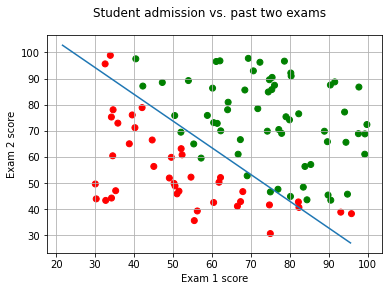

In [23]:
fig,ax = plt.subplots()
ax.scatter(X.Exam1, X.Exam2, c=colours)
ax.plot(plot_x, plot_y)
ax.grid(True)
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
fig.suptitle("Student admission vs. past two exams")

The blue line is our decision boundary: when your exams score lie below the line then probably (that is the prediction) you will not be admitted to University. If they lie above, probably you will.
As you can see, the boundary is not predicting perfectly on the training historical data. It's a model. Not perfect but useful. What we can do is to measure its accuracy.

## Accuracy

In [24]:
def logPredict(modelParams, X):  
    probabilities = modelParams.predict(X)
    return [1 if x >= 0.5 else 0 for x in probabilities]

In [25]:
predictions = logPredict(result, X)

In [26]:
accuracy = np.mean(predictions == y)
print ('accuracy = {0}%'.format(accuracy*100)  )

accuracy = 89.0%


Just for fun, let's say that my scores are 40 in the first exam and 78 in the second one:

In [27]:
myExams = pd.DataFrame({'Exam1': [40.], 'Exam2': [78.], 'intercept': [1.]})
myExams

,Exam1,Exam2,intercept
0,40.0,78.0,1.0


In [28]:
print ('Your probability = {0}%'.format(result.predict(myExams)[0]*100))

Your probability = 23.195940705038893%


Uh oh, looks's like my probability to be admitted at University is only 23% ...